In [3]:
import numpy as np
import cv2 as cv
from mcf.detection import Detector, DetectionStatus
from mcf.data_types import DetectionRegion
from matplotlib import pyplot as plt
from time import time

detector = Detector()

In [134]:
def pre_process(frame):
    if frame is not None:
        frame = cv.GaussianBlur(frame, (7,7), 2) 
        # frame = cv.bilateralFilter(frame, -1,7,7)  
        frame = frame.astype('float')
        # frame = decimate(frame, 2).astype('float64')
    return frame

def plot_motion_block(motion_block):
    Y = []
    X = []
    for y in range(motion_block.shape[0]):
        for x in range(motion_block.shape[1]):
            y_value = motion_block[y,x,0]
            x_value = motion_block[y,x,1]
            if y_value != 0 and x_value != 0:
                Y.append(y_value)
                X.append(x_value)

    plt.figure()
    plt.plot(X, Y, 'o')
    plt.title(f'motion vectors')
    plt.ylabel(f'y-value')
    plt.xlabel(f'x-value')
    plt.grid()
    print(f'mean yx: {np.median(Y)},{np.median(X)}')


In [135]:
# Load Sequential Frames from Video
video = cv.VideoCapture(f'/Users/elyons/Documents/dev/repos/motion_compensated_filtering_for_image_recovery/prototype/data/highway.mp4')
for _ in range(150): # advance partway because there is more motion further into the video
    _, frame = video.read()
_, frame_last = video.read()
_, frame_current = video.read()

# get detection regions
_, detection_regions_last = detector.run(frame_last)
_, detection_regions_current = detector.run(frame_current)

frame_last = pre_process(frame_last)
frame_current = pre_process(frame_current)

# plt.figure(figsize=(10,10))
# plt.imshow(frame_current / np.max(frame_current))

mean yx: -5.0,3.0
mean yx: -4.0,6.0
mean yx: -4.0,4.0


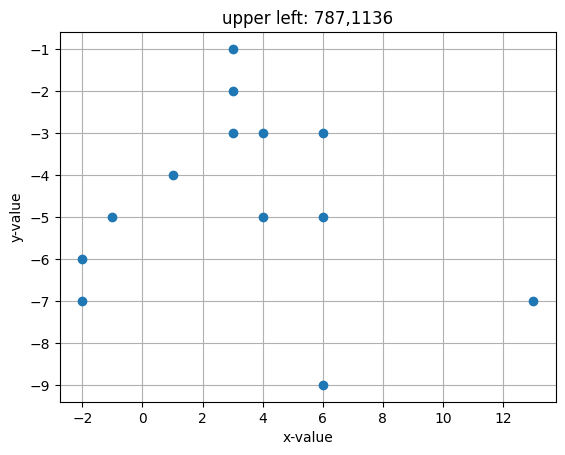

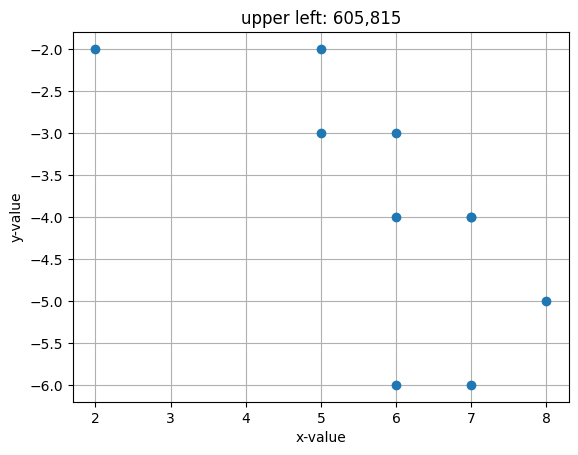

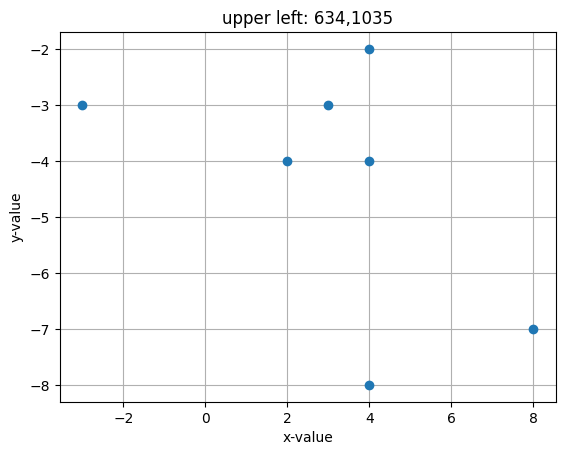

In [150]:
def get_search_region(bounding_box, frame_shape, block_size):
    (xl,yl),(xh,yh) = detection_region.bounding_box
    
    # truncate any blocks that run over image boundaries
    yl = min(max(yl, block_size[0]//2), frame_shape[0]-block_size[0]//2)
    yh = min(max(yh, block_size[0]//2), frame_shape[0]-block_size[0]//2)
    xl = min(max(xl, block_size[1]//2), frame_shape[1]-block_size[1]//2)
    xh = min(max(xh, block_size[1]//2), frame_shape[1]-block_size[1]//2)

    return yl,yh,xl,xh

def opticalFlow(frame: np.array, bounding_box, mask: np.array, frame_last: np.array, block_size: tuple[int, int]):
    motion_block = np.zeros(mask.shape)
    yl,yh,xl,xh = get_search_region(bounding_box, frame_current.shape, block_size)

    frame_out = frame.copy().astype('uint8')

    for y in range(yl, yh, block_size[0]):
        for x in range(xl, xh, block_size[1]):

            if (mask[y-yl,x-xl,:] != (-1,-1)).any(): # only measure pixels that are in the detection region mask

                ylow = y - block_size[0]//2
                yhigh = y + block_size[0]//2+1

                xlow = x - block_size[1]//2
                xhigh = x + block_size[1]//2+1

                # dx + dy = -dt
                block_y1 = frame[ylow:yhigh, xlow:xhigh]
                block_y3 = frame[ylow+1:yhigh+1, xlow:xhigh]
                dy = (block_y3 - block_y1)/2

                block_x1 = frame[ylow:yhigh, xlow:xhigh]
                block_x3 = frame[ylow:yhigh, xlow+1:xhigh+1]
                dx = (block_x3 - block_x1)/2

                block_1 = frame[ylow:yhigh, xlow:xhigh]
                block_2 = frame_last[ylow:yhigh, xlow:xhigh]

                dt = block_2 - block_1

                IxIx = np.sum(np.power(dx,2))
                IyIy = np.sum(np.power(dy,2))
                IxIy = np.sum(dx*dy)
                IxIt = np.sum(dx*dt)
                IyIt = np.sum(dy*dt)

                #Ax = B
                # x = inv(AtA)AtB
                AtA = np.array([[IxIx, IxIy], [IxIy, IyIy]])
                AtB = np.array([[IxIt], [IyIt]])
                uv = np.linalg.inv(AtA) @ AtB

                start_point = np.array([x-int(uv[0][0]), y-int(uv[1][0])])
                end_point = np.array([x, y])
                
                motion_block[y-yl, x-xl] = np.array([end_point[1]-start_point[1], end_point[0]-start_point[0]])

                magnitude = np.linalg.norm(np.array(end_point) - np.array(start_point))
                frame_out = cv.arrowedLine(frame_out[:,:,], (start_point), (end_point), (25,255,25), 2)

    plot_motion_block(motion_block)
    plt.title(f'upper left: {yl},{xl}')

    return motion_block, frame_out


frames_out = []
for detection_region in detection_regions_current:
    bounding_box = detection_region.bounding_box
    mask = detection_region.mask
    motion_block, frame_out = opticalFlow(frame_current, bounding_box, mask, frame_last, (32,32))
    frames_out.append(frame_out)
    

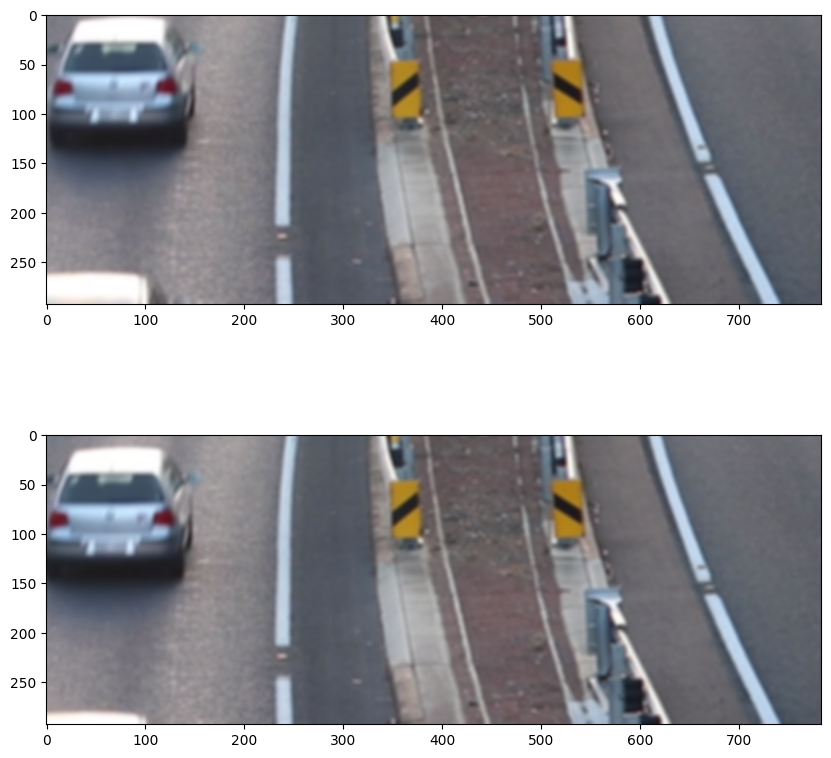

In [151]:
current = frame_current[..., ::-1]/np.max(frame_current)
last = frame_last[..., ::-1]/np.max(frame_last)

from_y = 787
from_x = 1136
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(current[from_y:,from_x:])
plt.subplot(212)
plt.imshow(last[from_y:,from_x:])
plt.show()

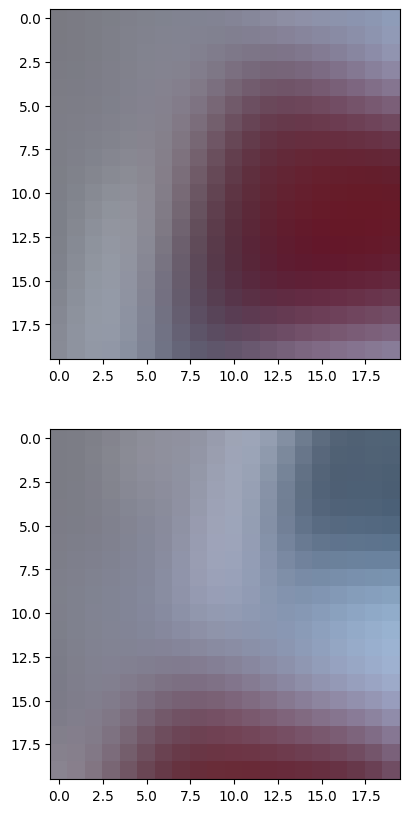

In [152]:
current = frame_current[..., ::-1]/np.max(frame_current)
last = frame_last[..., ::-1]/np.max(frame_last)

from_y = 850
from_x = 1136
window_size = 20
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(current[from_y:from_y+window_size,from_x:from_x+window_size])
plt.subplot(212)
plt.imshow(last[from_y:from_y+window_size,from_x:from_x+window_size])
plt.show()

# 6,10
# 17,5

# motion: <-11,5>

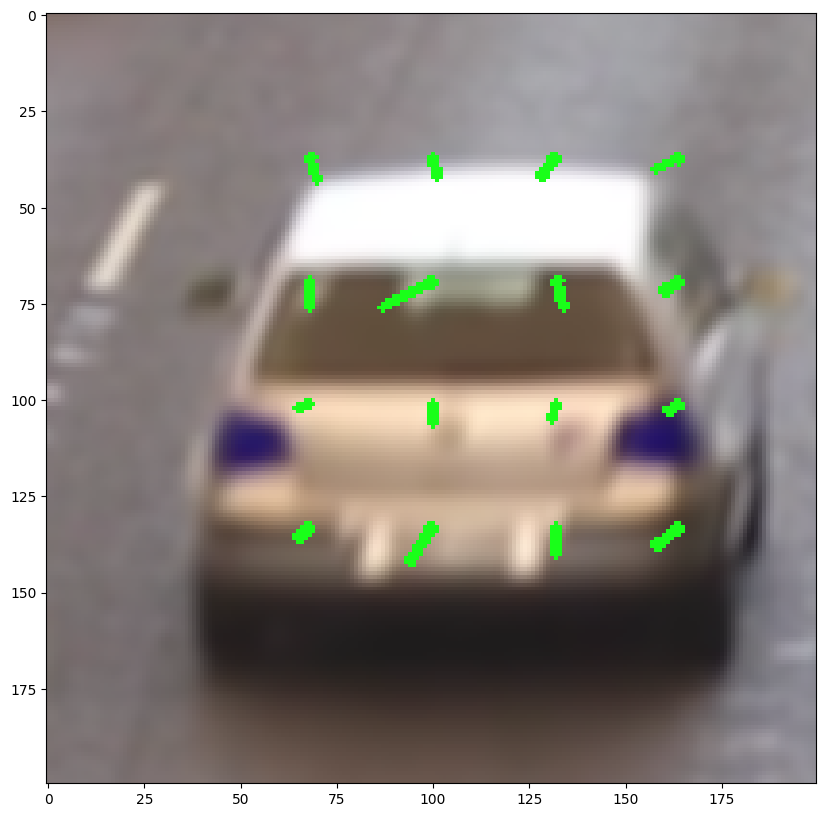

In [153]:
plt.figure(figsize=(10,10))
plt.imshow(frames_out[0][750:950,1100:1300])